In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
from phonenumbers.phonenumberutil import region_code_for_country_code 
from IPython.display import display
import datetime
from pandas.api.types import CategoricalDtype

# Data Cleaning & Preparation

In [2]:
colnames=['datetime', 'CellID', 'countrycode', 'smsin','smsout','callin','callout','internet']
df_cdr = pd.DataFrame({})
for i in range(1,8):
    data = pd.read_csv('sms-call-internet-mi-2013-11-0{}.txt'.format(i),delimiter='\t',names=colnames)
    df_cdr = pd.concat([df_cdr,data])
df_cdr

,datetime,CellID,countrycode,smsin,smsout,callin,callout,internet
0,2013-11-01 00:00:00,1,0,0.3521,NaN,NaN,0.0273,NaN
1,2013-11-01 00:00:00,1,33,NaN,NaN,NaN,NaN,0.0261
2,2013-11-01 00:00:00,1,39,1.7322,1.1047,0.5919,0.4020,57.7729
3,2013-11-01 00:00:00,2,0,0.3581,NaN,NaN,0.0273,NaN
4,2013-11-01 00:00:00,2,33,NaN,NaN,NaN,NaN,0.0274
...,...,...,...,...,...,...,...,...
2407379,2013-11-07 23:00:00,10000,7,NaN,NaN,NaN,NaN,0.0872
2407380,2013-11-07 23:00:00,10000,39,4.3872,2.9300,2.6409,0.6442,135.6360
2407381,2013-11-07 23:00:00,10000,40,0.0860,NaN,NaN,NaN,NaN
2407382,2013-11-07 23:00:00,10000,216,0.0095,NaN,NaN,NaN,NaN


In [3]:
# Converting object dtype to datetime dtype
df_cdr['datetime'] = pd.to_datetime(df_cdr['datetime'])

In [4]:
#Splitting the datetime column into date and time columns
df = df_cdr.copy()

df['date'] = df['datetime'].dt.date
df['time'] = df['datetime'].dt.time

In [5]:
df.isnull().sum()

datetime              0
CellID                0
countrycode           0
smsin           9065620
smsout         11542655
callin         10979856
callout         8604862
internet        8369201
date                  0
time                  0
dtype: int64

In [5]:
# Filling NaN values with 0
df = df.fillna(0)

In [64]:
df.countrycode.nunique()

326

In [6]:
# Adding new country column using countrycode column
def code2country(code):
    alpha = region_code_for_country_code(code)
    country = pycountry.countries.get(alpha_2=alpha)
    
    if country is None:
        
        try:
            pn = phonenumbers.parse('+{}**1234567'.format(str(i))) 
            country = pycountry.countries.get(alpha_2 = region_code_for_number(pn)) 
            return country.name
        
        except Exception as e:
            return code

    if ',' in country.name:
        return country.name[:country.name.find(',')]
    return country.name

df['country'] = [code2country(i) for i in df['countrycode']]

In [7]:
# Creating weekday column
conditions = [
    (df['date'] == datetime.date(2013, 11, 1)),
    (df['date'] == datetime.date(2013, 11, 2)),
    (df['date'] == datetime.date(2013, 11, 3)),
    (df['date'] == datetime.date(2013, 11, 4)),
    (df['date'] == datetime.date(2013, 11, 5)),
    (df['date'] == datetime.date(2013, 11, 6)),
    (df['date'] == datetime.date(2013, 11, 7))]
     
choices = ['Fri', 'Sat', 'Sun', 'Mon', 'Tue', 'Wed','Thu']
df['weekday'] = np.select(conditions, choices)

In [8]:
# Reordering columns and remove datetime column
df = df[['date','time','weekday','CellID','country','countrycode','smsin','smsout','callin','callout','internet']]
df = df.reset_index(drop=True)
df

,date,time,weekday,CellID,country,countrycode,smsin,smsout,callin,callout,internet
0,2013-11-01,00:00:00,Fri,1,0,0,0.3521,0.0000,0.0000,0.0273,0.0000
1,2013-11-01,00:00:00,Fri,1,France,33,0.0000,0.0000,0.0000,0.0000,0.0261
2,2013-11-01,00:00:00,Fri,1,Italy,39,1.7322,1.1047,0.5919,0.4020,57.7729
3,2013-11-01,00:00:00,Fri,2,0,0,0.3581,0.0000,0.0000,0.0273,0.0000
4,2013-11-01,00:00:00,Fri,2,France,33,0.0000,0.0000,0.0000,0.0000,0.0274
...,...,...,...,...,...,...,...,...,...,...,...
15089160,2013-11-07,23:00:00,Thu,10000,Russian Federation,7,0.0000,0.0000,0.0000,0.0000,0.0872
15089161,2013-11-07,23:00:00,Thu,10000,Italy,39,4.3872,2.9300,2.6409,0.6442,135.6360
15089162,2013-11-07,23:00:00,Thu,10000,Romania,40,0.0860,0.0000,0.0000,0.0000,0.0000
15089163,2013-11-07,23:00:00,Thu,10000,Tunisia,216,0.0095,0.0000,0.0000,0.0000,0.0000


In [9]:
# Total amount of call and SMS IN/OUT CDR 
sms_type = pd.Series(['smsin','smsin','smsin','smsin','smsin','smsin','smsin','smsout','smsout','smsout','smsout','smsout','smsout','smsout'],name='smstype')
call_type = pd.Series(['callin','callin','callin','callin','callin','callin','callin','callout','callout','callout','callout','callout','callout','callout'],name='calltype')

sms_in = df.groupby('weekday')['smsin'].sum().reset_index(name='sms_sum')
sms_out = df.groupby('weekday')['smsout'].sum().reset_index(name='sms_sum')

call_in = df.groupby('weekday')['callin'].sum().reset_index(name='call_sum')
call_out = df.groupby('weekday')['callout'].sum().reset_index(name='call_sum')

sms_concat = pd.concat([sms_in,sms_out],ignore_index=True)
call_concat = pd.concat([call_in,call_out],ignore_index=True)

call_sms_df = pd.concat([sms_concat,sms_type,call_concat[['call_sum']],call_type],axis=1,ignore_index=True)

call_sms_df = call_sms_df.rename(columns={0:'weekday',1:'sum_sms',2:'sms_type',3:'sum_call',4:'call_type'})

cats = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

call_sms_df['weekday'] = pd.Categorical(call_sms_df['weekday'], categories=cats, ordered=True)

call_sms_df = call_sms_df.sort_values('weekday')

call_sms_df

,weekday,sum_sms,sms_type,sum_call,call_type
1,Mon,7.742700e+06,smsin,5.409634e+06,callin
8,Mon,4.288716e+06,smsout,6.166560e+06,callout
5,Tue,7.931791e+06,smsin,5.692466e+06,callin
12,Tue,4.368527e+06,smsout,6.476255e+06,callout
6,Wed,7.947298e+06,smsin,5.702409e+06,callin
13,Wed,4.351456e+06,smsout,6.340527e+06,callout
4,Thu,8.144554e+06,smsin,5.648970e+06,callin
11,Thu,4.286852e+06,smsout,6.231774e+06,callout
0,Fri,4.606387e+06,smsin,2.622800e+06,callin
7,Fri,2.822430e+06,smsout,3.196762e+06,callout


In [10]:
internet_df = df.groupby('weekday')['internet'].sum().rename_axis('weekday').reset_index(name='internet')
internet_df['weekday'] = pd.Categorical(internet_df['weekday'], categories=cats, ordered=True)
internet_df = internet_df.sort_values('weekday')

internet_df

,weekday,internet
1,Mon,1.081069e+08
5,Tue,1.111241e+08
6,Wed,1.110092e+08
4,Thu,1.103965e+08
0,Fri,8.247925e+07
2,Sat,8.099102e+07
3,Sun,8.350916e+07


# Explatory Data Analysis

### Observation 1: Date & Time & Weekday

In [11]:
sns.set_style(style='darkgrid')

sns.set_palette(palette="icefire")

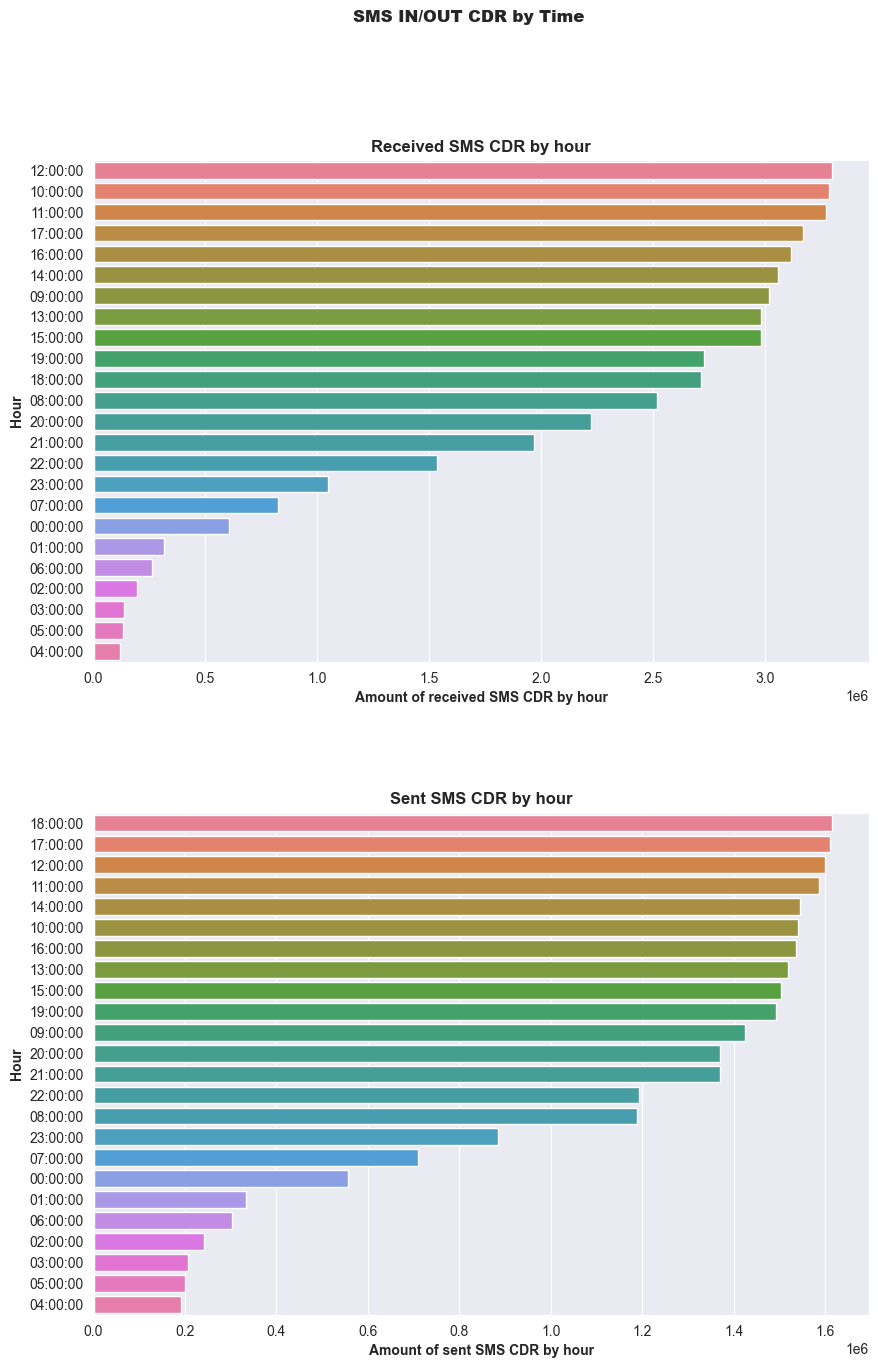

In [34]:
# SMS IN & OUT CDR activity by hour
smsin_by_hour = df.groupby('time')[['smsin']].sum().reset_index().sort_values(by=['smsin'],ascending=False)
smsout_by_hour = df.groupby('time')[['smsout']].sum().reset_index().sort_values(by=['smsout'],ascending=False)

fig, ax = plt.subplots(2,1,figsize=(10,15))

fig.suptitle('SMS IN/OUT CDR by Time',fontweight='heavy')

sns.barplot(ax=ax[0],data=smsin_by_hour,x='smsin',y='time',hue='time',legend=False,errorbar=None)
sns.barplot(ax=ax[1],data=smsout_by_hour,x='smsout',y='time',hue='time',legend=False,errorbar=None)

plt.subplots_adjust(hspace = 0.3)

ax[0].set_title('Received SMS CDR by hour',fontweight='bold')
ax[0].set_xlabel('Amount of received SMS CDR by hour',fontweight='bold')
ax[0].set_ylabel('Hour',fontweight='bold')

ax[1].set_title('Sent SMS CDR by hour',fontweight='bold')
ax[1].set_xlabel('Amount of sent SMS CDR by hour',fontweight='bold')
ax[1].set_ylabel('Hour',fontweight='bold')

plt.show()

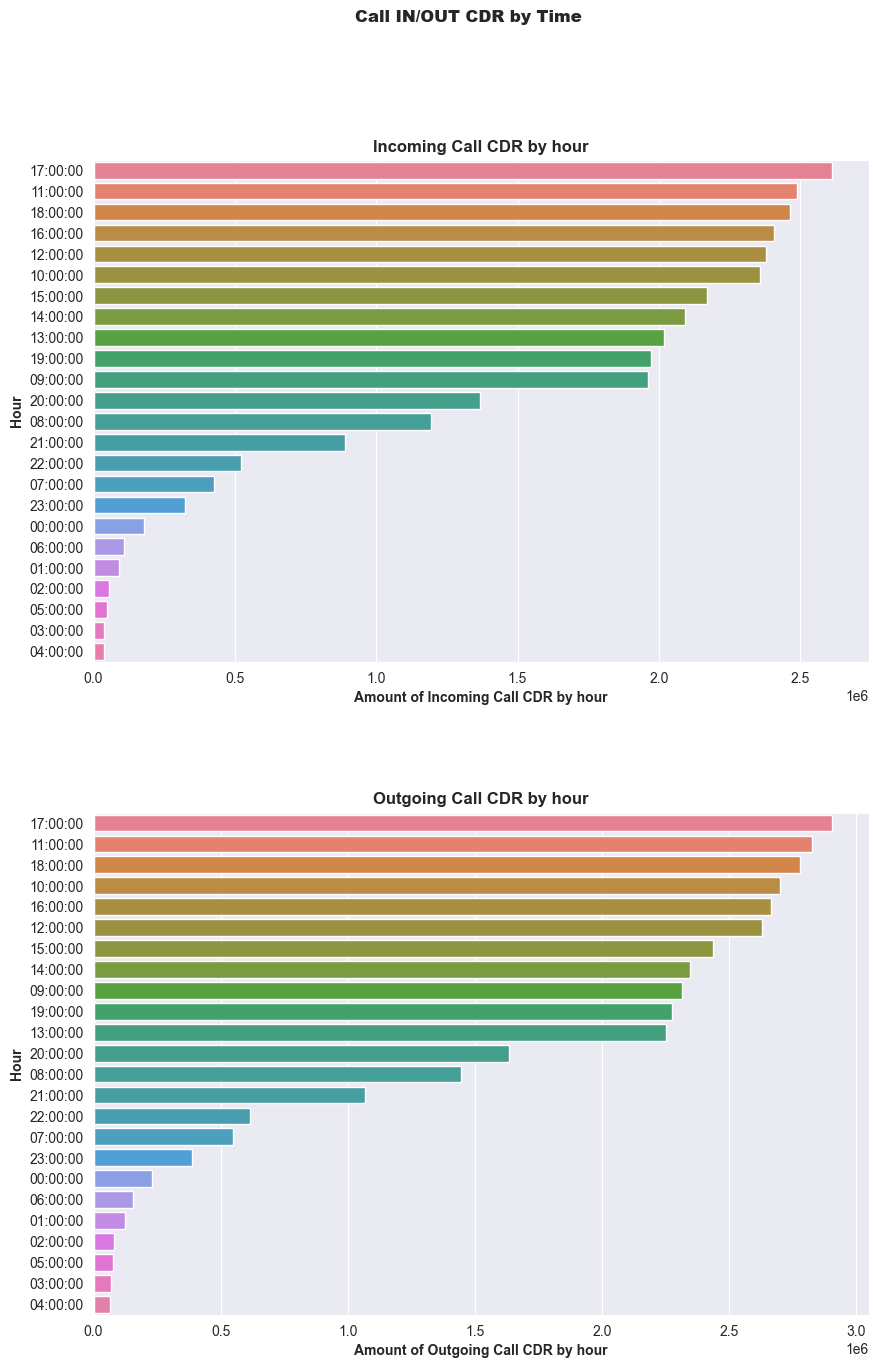

In [36]:
# Call IN & OUT CDR activity by time
callin_by_hour = df.groupby('time')[['callin']].sum().reset_index().sort_values(by=['callin'],ascending=False)
callout_by_hour = df.groupby('time')[['callout']].sum().reset_index().sort_values(by=['callout'],ascending=False)

fig, ax = plt.subplots(2,1,figsize=(10,15))

fig.suptitle('Call IN/OUT CDR by Time',fontweight='heavy')

sns.barplot(ax=ax[0],data=callin_by_hour,x='callin',y='time',hue='time',legend=False,errorbar=None)
sns.barplot(ax=ax[1],data=callout_by_hour,x='callout',y='time',hue='time',legend=False,errorbar=None)

plt.subplots_adjust(hspace = 0.3)

ax[0].set_title('Incoming Call CDR by hour',fontweight='bold')
ax[0].set_xlabel('Amount of Incoming Call CDR by hour',fontweight='bold')
ax[0].set_ylabel('Hour',fontweight='bold')

ax[1].set_title('Outgoing Call CDR by hour',fontweight='bold')
ax[1].set_xlabel('Amount of Outgoing Call CDR by hour',fontweight='bold')
ax[1].set_ylabel('Hour',fontweight='bold')

plt.show()

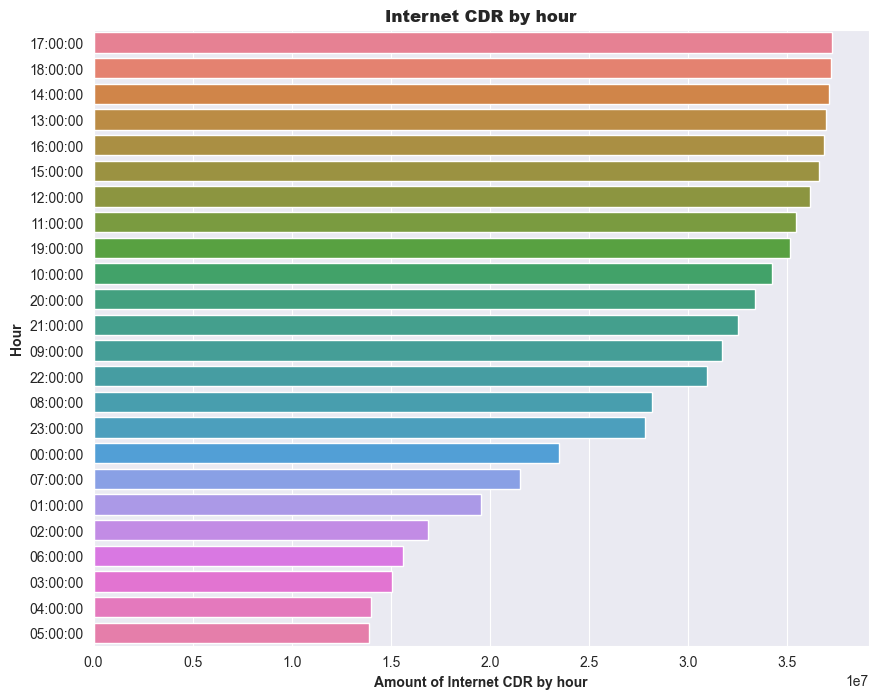

In [38]:
# Internet CDR by Time
internet_by_hour = df.groupby('time')['internet'].sum().reset_index().sort_values(by=['internet'],ascending=False)

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(ax=ax,data=internet_by_hour,x='internet',y='time',hue='time',legend=False,errorbar=None)
ax.set_title('Internet CDR by hour',fontweight='heavy')
ax.set_xlabel('Amount of Internet CDR by hour',fontweight='bold')
ax.set_ylabel('Hour',fontweight='bold')

plt.show()

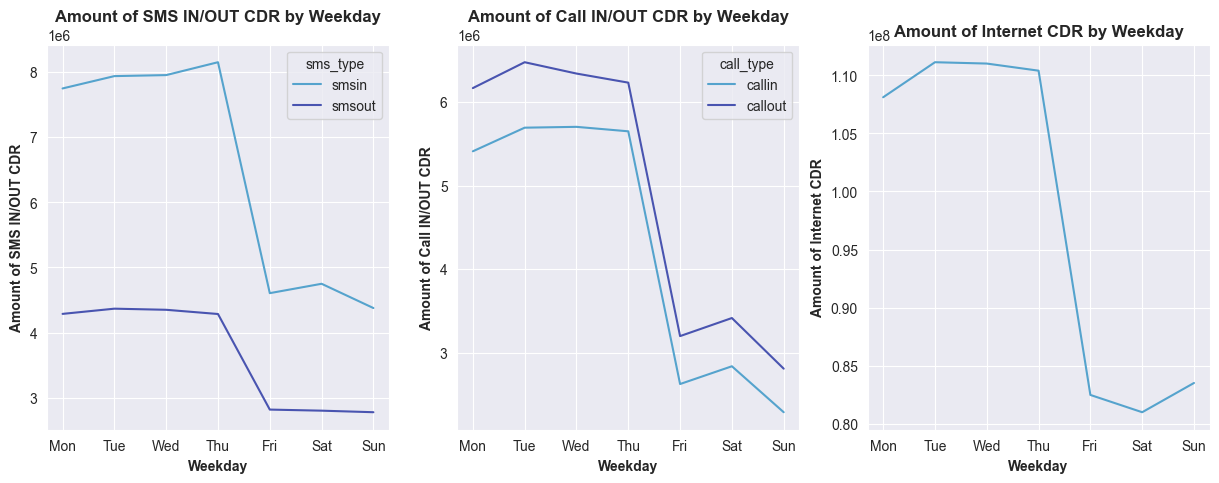

In [51]:
# SMS IN/OUT CDR by Weekday

fig, ax = plt.subplots(1,3,figsize=(15,5))

sns.lineplot(ax=ax[0],data=call_sms_df,x='weekday',y='sum_sms',hue='sms_type')
sns.lineplot(ax=ax[1],data=call_sms_df,x='weekday',y='sum_call',hue='call_type')
sns.lineplot(ax=ax[2],data=internet_df,x='weekday',y='internet')

ax[0].set_title('Amount of SMS IN/OUT CDR by Weekday',fontweight='bold')
ax[0].set_xlabel('Weekday',fontweight='bold')
ax[0].set_ylabel('Amount of SMS IN/OUT CDR',fontweight='bold')

ax[1].set_title('Amount of Call IN/OUT CDR by Weekday',fontweight='bold')
ax[1].set_xlabel('Weekday',fontweight='bold')
ax[1].set_ylabel('Amount of Call IN/OUT CDR',fontweight='bold')


ax[2].set_title('Amount of Internet CDR by Weekday',fontweight='bold')
ax[2].set_xlabel('Weekday',fontweight='bold')
ax[2].set_ylabel('Amount of Internet CDR',fontweight='bold')

plt.show()

### Observation 2: Cell ID

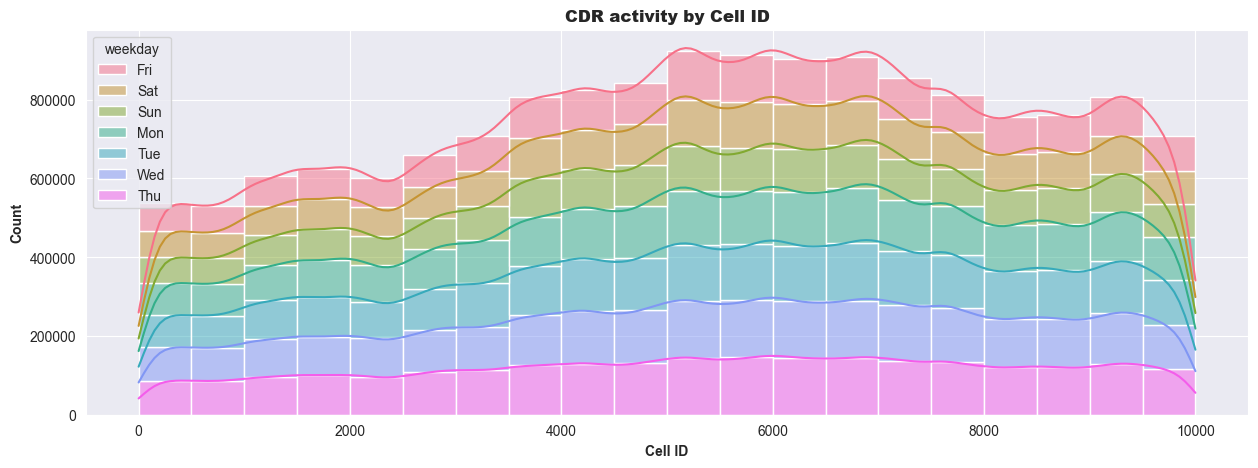

In [75]:
# CDR activity by Cell ID
plt.figure(figsize=(15,5))

cell_hist = sns.histplot(data=df,x='CellID',bins=20,hue="weekday", multiple="stack",kde=True,color='blue')

cell_hist.set_title('CDR activity by Cell ID and Weekday',fontweight='heavy')
cell_hist.set_xlabel('Cell ID',fontweight='bold')
cell_hist.set_ylabel('Count',fontweight='bold')

plt.show()

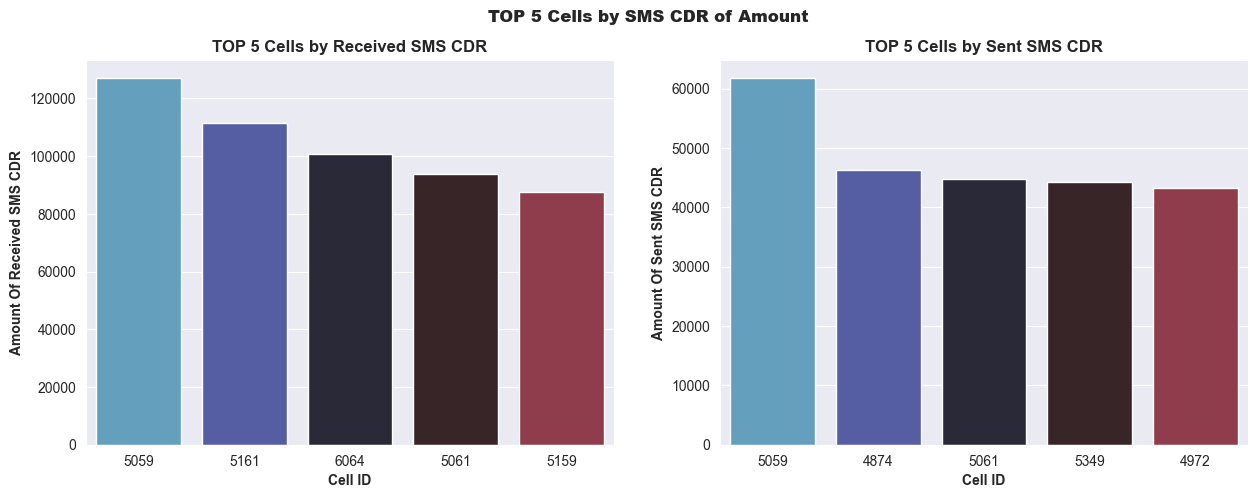

In [77]:
cell_smsin = df.groupby('CellID')['smsin'].sum().rename_axis('CellID').reset_index(name='sum_sms').sort_values('sum_sms',ascending=False).head(5)
cell_smsout = df.groupby('CellID')['smsout'].sum().rename_axis('CellID').reset_index(name='sum_sms').sort_values('sum_sms',ascending=False).head(5)

cell_smsin = cell_smsin.reset_index(drop=True)
cell_smsout = cell_smsout.reset_index(drop=True)

cell_smsin['CellID'] = cell_smsin['CellID'].astype('str')
cell_smsout['CellID'] = cell_smsout['CellID'].astype('str')

fig,ax = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('TOP 5 Cells Amount by of SMS CDR',fontweight='heavy')

sns.barplot(ax=ax[0],data=cell_smsin,x='CellID',y='sum_sms',hue='CellID',legend=False)
sns.barplot(ax=ax[1],data=cell_smsout,x='CellID',y='sum_sms',hue='CellID',legend=False)

ax[0].set_title('TOP 5 Cells by Received SMS CDR',fontweight='bold')
ax[0].set_xlabel('Cell ID',fontweight='bold')
ax[0].set_ylabel('Amount Of Received SMS CDR',fontweight='bold')

ax[1].set_title('TOP 5 Cells by Sent SMS CDR',fontweight='bold')
ax[1].set_xlabel('Cell ID',fontweight='bold')
ax[1].set_ylabel('Amount Of Sent SMS CDR',fontweight='bold')

plt.show()

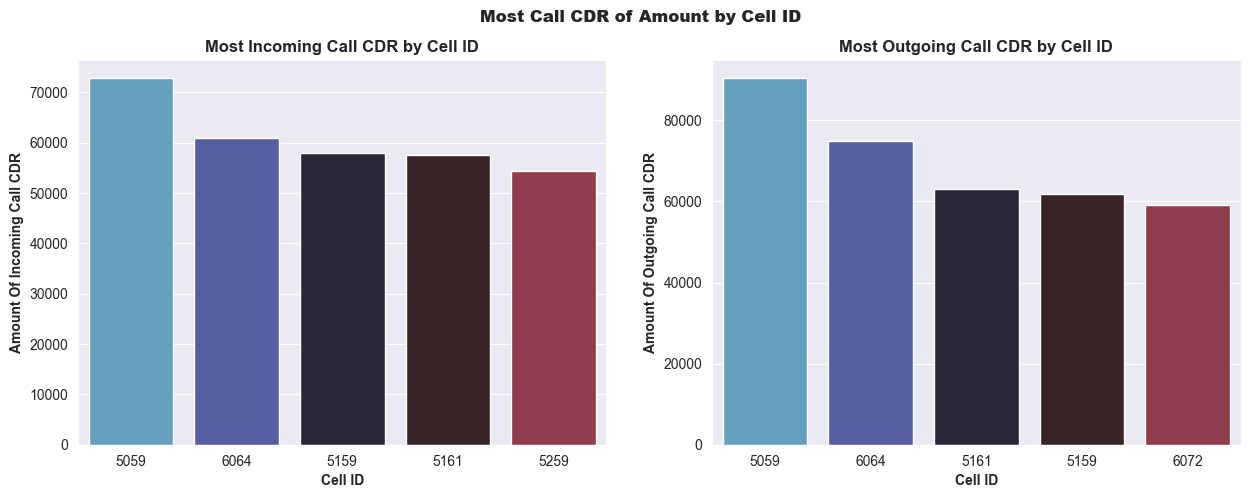

In [60]:
cell_callin = df.groupby('CellID')['callin'].sum().rename_axis('CellID').reset_index(name='sum_call').sort_values('sum_call',ascending=False).head(5)
cell_callout = df.groupby('CellID')['callout'].sum().rename_axis('CellID').reset_index(name='sum_call').sort_values('sum_call',ascending=False).head(5)

cell_callin = cell_callin.reset_index(drop=True)
cell_callout = cell_callout.reset_index(drop=True)

cell_callin['CellID'] = cell_callin['CellID'].astype('str')
cell_callout['CellID'] = cell_callout['CellID'].astype('str')

fig,ax = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Most Call CDR of Amount by Cell ID',fontweight='heavy')

sns.barplot(ax=ax[0],data=cell_callin,x='CellID',y='sum_call',hue='CellID',legend=False)
sns.barplot(ax=ax[1],data=cell_callout,x='CellID',y='sum_call',hue='CellID',legend=False)

plt.subplots_adjust(hspace = 0.3)

ax[0].set_title('Most Incoming Call CDR by Cell ID',fontweight='bold')
ax[0].set_xlabel('Cell ID',fontweight='bold')
ax[0].set_ylabel('Amount Of Incoming Call CDR',fontweight='bold')

ax[1].set_title('Most Outgoing Call CDR by Cell ID',fontweight='bold')
ax[1].set_xlabel('Cell ID',fontweight='bold')
ax[1].set_ylabel('Amount Of Outgoing Call CDR',fontweight='bold')

plt.show()

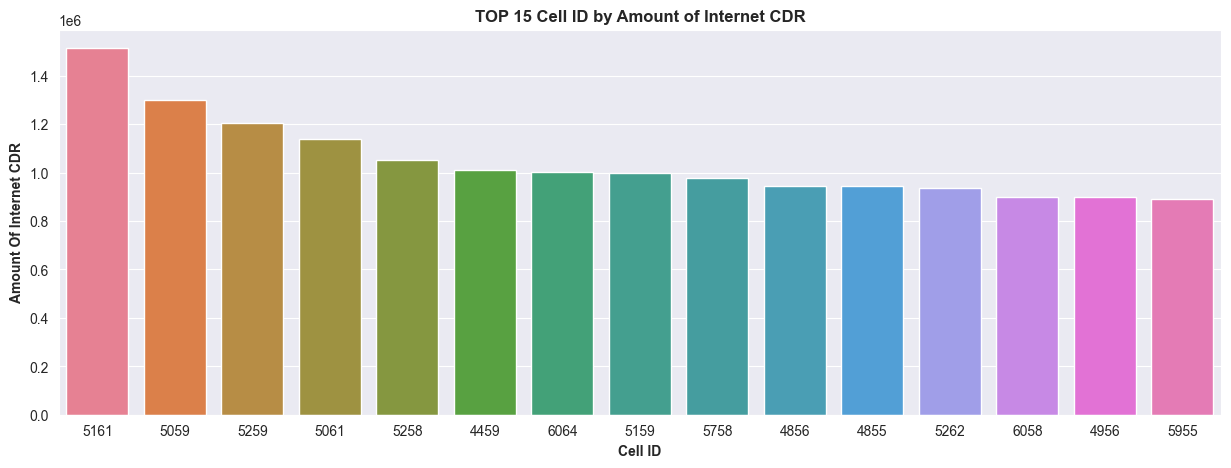

In [83]:
plt.figure(figsize=(15,5))

cell_internet = df.groupby('CellID')['internet'].sum().rename_axis('CellID').reset_index(name='internet').sort_values('internet',ascending=False).head(15)
cell_internet = cell_internet.reset_index(drop=True)
cell_internet['CellID'] = cell_internet['CellID'].astype('str')

in_bar = sns.barplot(data=cell_internet,x='CellID',y='internet',hue='CellID',legend=False)

in_bar.set_title('TOP 15 Cell ID by Amount of Internet CDR',fontweight='bold')
in_bar.set_xlabel('Cell ID',fontweight='bold')
in_bar.set_ylabel('Amount Of Internet CDR',fontweight='bold')

plt.show()

### Observation 3: Country

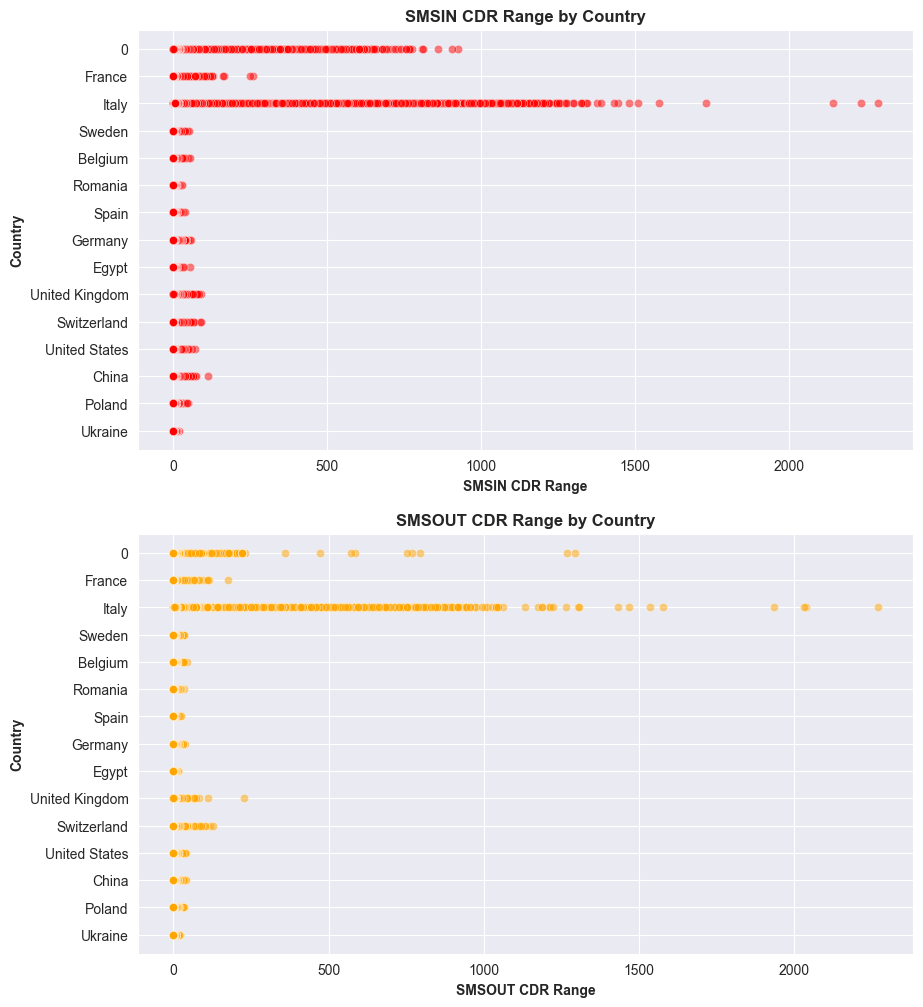

In [36]:
fig,ax = plt.subplots(2,1,figsize=(10,12))

country_df = df['country'].value_counts().reset_index().head(15)
country_df = df[df['country'].isin(country_df['country'].to_list())]

country_df.loc[:, 'country'] = country_df['country'].astype('str')

sns.scatterplot(ax=ax[0],data=country_df,y='country',x='smsin',color='red',alpha=0.5)
sns.scatterplot(ax=ax[1],data=country_df,y='country',x='smsout',color='orange',alpha=0.5)

ax[0].set_title('SMSIN CDR Range by Country',fontweight='bold')
ax[0].set_ylabel('Country',fontweight='bold')
ax[0].set_xlabel('SMSIN CDR Range',fontweight='bold')

ax[1].set_title('SMSOUT CDR Range by Country',fontweight='bold')
ax[1].set_ylabel('Country',fontweight='bold')
ax[1].set_xlabel('SMSOUT CDR Range',fontweight='bold')

plt.show()

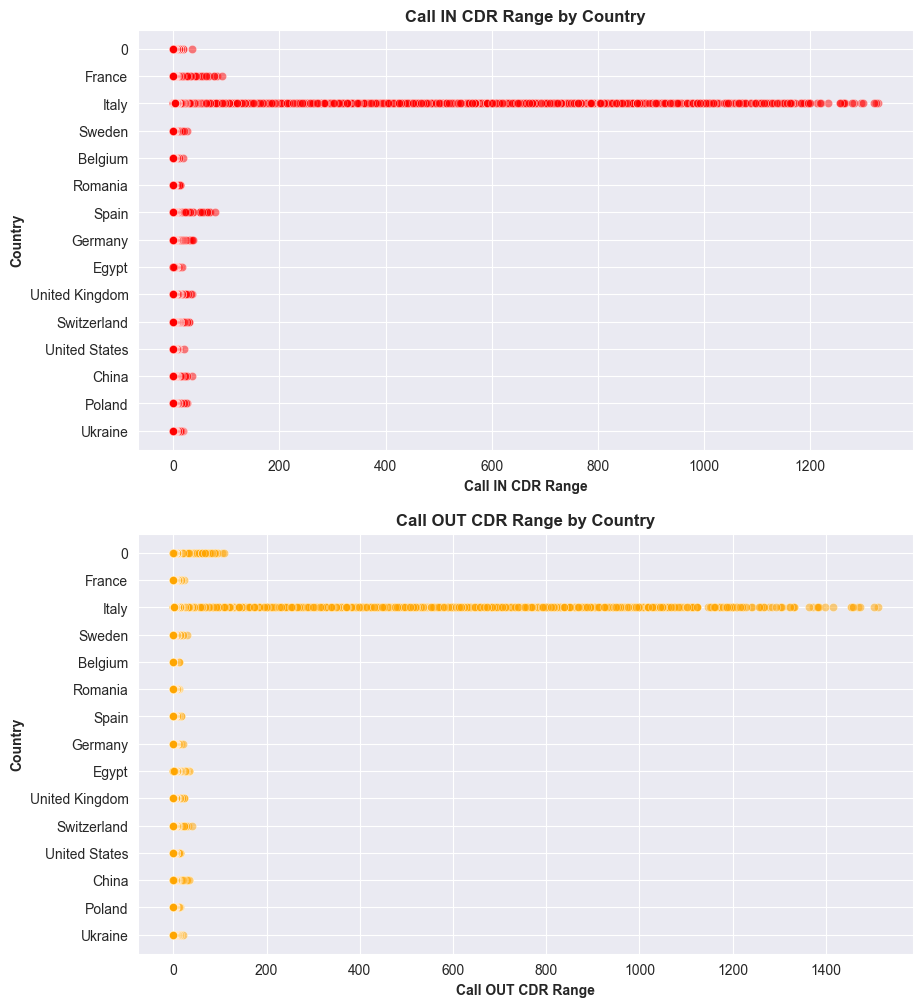

In [12]:
fig,ax = plt.subplots(2,1,figsize=(10,12))

country_df = df['country'].value_counts().reset_index().head(15)
country_df = df[df['country'].isin(country_df['country'].to_list())]

country_df.loc[:, 'country'] = country_df['country'].astype('str')

sns.scatterplot(ax=ax[0],data=country_df,y='country',x='callin',color='red',alpha=0.5)
sns.scatterplot(ax=ax[1],data=country_df,y='country',x='callout',color='orange',alpha=0.5)

ax[0].set_title('Call IN CDR Range by Country',fontweight='bold')
ax[0].set_ylabel('Country',fontweight='bold')
ax[0].set_xlabel('Call IN CDR Range',fontweight='bold')

ax[1].set_title('Call OUT CDR Range by Country',fontweight='bold')
ax[1].set_ylabel('Country',fontweight='bold')
ax[1].set_xlabel('Call OUT CDR Range',fontweight='bold')

plt.show()

In [9]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>
tyle>
